# Analyse de la pertinence de la variable EnergyStarScore

#### Contexte :

- A l'aide de relevés déjà effectué par les agents de la ville de Seattle, nous voulons prédire la consommation totate énergétique ainsi que les émissions de CO2 des bâtiments non résidentiels. 

- Nos données, issues du site de Seattle Open Data, ont été nettoyées et prétraitées.

- Pour analyser la pertinence de l'ENERGYSTARScore pour la prédiction des émissions de CO2, nous reprenons le modèle sélectionné dans le notebook de prédiction des émissions de CO2: XGBRegressor() et nous ferons le test avec la variable EnergyStarScore pour comparer les performances du modèle.

- Pour utiliser cette variable, dont le taux de complétion est d'environ 75%, nous allons restreindre nos données pour ne pas avoir de Nan sur cette variable.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings


In [2]:
data = pd.read_csv("final_data_2.csv", sep = ",")

In [3]:
df = data.loc[data['ENERGYSTARScore'].notna()]
df.shape

(3126, 21)

In [4]:
df.count()

OSEBuildingID                3126
BuildingType                 3126
PrimaryPropertyType          3126
CouncilDistrictCode          3126
Neighborhood                 3126
Latitude                     3126
Longitude                    3126
NumberofBuildings            3126
NumberofFloors               3126
PropertyGFATotal             3126
PropertyGFAParking           3126
PropertyGFABuilding(s)       3126
LargestPropertyUseType       3126
LargestPropertyUseTypeGFA    3126
ENERGYSTARScore              3126
SiteEnergyUse(kBtu)          3126
TotalGHGEmissions            3126
BuildingAge                  3126
Parking_Rate                 3126
Building_Rate                3126
Largest_Use_Rate             3126
dtype: int64

Redéfinir les types des variables catégorielles :

In [5]:
warnings.filterwarnings("ignore")

In [6]:
categorical_var=["BuildingType", "PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType", "CouncilDistrictCode"]
df[categorical_var] = df[categorical_var].astype('category')

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3126 entries, 0 to 4697
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   OSEBuildingID              3126 non-null   int64   
 1   BuildingType               3126 non-null   category
 2   PrimaryPropertyType        3126 non-null   category
 3   CouncilDistrictCode        3126 non-null   category
 4   Neighborhood               3126 non-null   category
 5   Latitude                   3126 non-null   float64 
 6   Longitude                  3126 non-null   float64 
 7   NumberofBuildings          3126 non-null   float64 
 8   NumberofFloors             3126 non-null   float64 
 9   PropertyGFATotal           3126 non-null   int64   
 10  PropertyGFAParking         3126 non-null   float64 
 11  PropertyGFABuilding(s)     3126 non-null   float64 
 12  LargestPropertyUseType     3126 non-null   category
 13  LargestPropertyUseTypeGFA  3126 non-nu

Nous allons supprimer les variables :

    - SiteEnergyUse(kBtu) (pour la prédiction de la consommation de CO2, les deux variables sont à prédire simultanément)
    - OSEBuildingID (variable d'identification inutile prédiction)
    - PropertyGFAbuilding(s), PropertyGFAParking, BuildingAge, Largest_Use_Rate, LargestPropertyUseTypeGFA (variables éliminées par la RFE dans le précédent notebook)

In [21]:
df_energy = df.copy()
df_energy = df_energy.drop(columns=['SiteEnergyUse(kBtu)', 'OSEBuildingID', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'BuildingAge', 'Largest_Use_Rate', 'LargestPropertyUseTypeGFA'])
df_energy.shape

(3126, 14)

In [22]:
import category_encoders

# Fonction transformation log de la variable cible
def target_transformation(value):
    return np.log(value)

# Fonction encodage :
def encodage(X_train, X_test, y_train):
    encoder = category_encoders.TargetEncoder()
    encoded_features = []
    
    for feature in X_train.columns:
        if X_train[feature].dtype.name == 'category':
            encoder.fit(X_train[feature], y_train)
            
            # Appliquez l'encodage à la fois sur X_train et X_test
            X_train[f'{feature}_encoded'] = encoder.transform(X_train[feature])
            X_test[f'{feature}_encoded'] = encoder.transform(X_test[feature])
            encoded_features.append(f'{feature}_encoded')
    
    return X_train[encoded_features], X_test[encoded_features]

In [23]:
# fonction pretraitement

def preprocessing(data, target):
    # Séparation features et cible
    X = data.drop([target], axis=1)
    y = data[target]

    # Transformation de la variable cible
    y_log = y.apply(target_transformation)
    
    # Séparer les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    # Séparation des variable numériques et catégorielles pour l'encodage
    train_categorical_features = X_train.select_dtypes(include='category')
    test_categorical_features = X_test.select_dtypes(include='category')
    
    train_numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
    test_numerical_features = X_test.select_dtypes(include=['int64', 'float64'])
    
    # Encodage des variables catégorielles
    train_categorical_features, test_categorical_features = encodage(train_categorical_features, test_categorical_features, y_train)
    
    # Fusion des variables catégorielles et numériques
    X_train = pd.merge(train_categorical_features, train_numerical_features, left_index=True, right_index=True)
    X_test = pd.merge(test_categorical_features, test_numerical_features,  left_index=True, right_index=True)

    print("Données d'entraînement : ", X_train.shape)
    print("Données de test : ", X_test.shape)

    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    return X_train, X_test, y_train, y_test

### 1 - En utilisant la variable ENERGYStarScore

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocessing(df_energy, 'TotalGHGEmissions')



Données d'entraînement :  (2500, 13)
Données de test :  (626, 13)


In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Grille d'hyperparamètres
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

# Création du modèle XGBoost
xgb_model = XGBRegressor()

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Exécuter la recherche d'hyperparamètres
grid_search.fit(X_train, y_train)

# Obtenir les meilleurs hyperparamètres
best_params = grid_search.best_params_
print(f'Best_params : {best_params}')

# Utiliser le modèle optimisé pour les prédictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Best_params : {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}


In [26]:
importance_scores = best_model.get_booster().get_score(importance_type='weight')

# Afficher les scores d'importance
print(f'Feature importance : \n {importance_scores}')

Feature importance : 
 {'BuildingType_encoded': 88.0, 'PrimaryPropertyType_encoded': 126.0, 'CouncilDistrictCode_encoded': 55.0, 'Neighborhood_encoded': 59.0, 'LargestPropertyUseType_encoded': 46.0, 'Latitude': 227.0, 'Longitude': 203.0, 'NumberofBuildings': 97.0, 'NumberofFloors': 236.0, 'PropertyGFATotal': 419.0, 'ENERGYSTARScore': 220.0, 'Parking_Rate': 130.0, 'Building_Rate': 32.0}


La variable ENERGYSTARScore a un score d'importance de 220, ce qui signifie que la variable est l'une des plus importante pour notre modèle.

In [27]:
from sklearn.metrics import *

RMSE = mean_squared_error(y_test, y_pred, squared=False)
Relative_RMSE = (RMSE/(y_train.max()-y_train.min()))*100
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print("Avec la variable EnergyStarScore")
print("---------------------------------------")
print(f'R2 : {R2}') 
print(f'RMSE : {RMSE}')
print(f'Relative_RMSE : {Relative_RMSE}')
print(f'MAE : {MAE}')

Avec la variable EnergyStarScore
---------------------------------------
R2 : 0.6810407687485013
RMSE : 302.0828752095248
Relative_RMSE : 1.7906597969019704
MAE : 69.66378702021254


### 3 - Sans utiliser la variable ENERGYStarScore

In [28]:
df_no_StarScore = df_energy.copy()
df_no_StarScore = df_no_StarScore.drop(columns=['ENERGYSTARScore'])
df_no_StarScore.shape

(3126, 13)

In [29]:
X_train_2, X_test_2, y_train_2, y_test_2 = preprocessing(df_no_StarScore, 'TotalGHGEmissions')

Données d'entraînement :  (2500, 12)
Données de test :  (626, 12)


In [30]:
import xgboost as xgb
# On utilise les meilleurs paramètres trouvés précédemment
model_xgb = xgb.XGBRegressor(max_depth = 3, learning_rate = 0.2, n_estimators = 300)
model_xgb.fit(X_train_2, y_train_2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
y_pred_2 = model_xgb.predict(X_test_2)

RMSE_2 = mean_squared_error(y_test_2, y_pred_2, squared=False)
Relative_RMSE_2 = (RMSE_2/(y_train_2.max()-y_train_2.min()))*100
MAE_2 = mean_absolute_error(y_test_2, y_pred_2)
R2_2 = r2_score(y_test_2, y_pred_2)
print("Sans la variable EnergyStarScore")
print("---------------------------------------")
print(f'R2 : {R2_2}')
print(f'RMSE : {RMSE_2}')
print(f'Relative_RMSE : {Relative_RMSE_2}')
print(f'MAE : {MAE_2}')


Sans la variable EnergyStarScore
---------------------------------------
R2 : 0.7769319959480927
RMSE : 252.62548421128648
Relative_RMSE : 1.4974907066025598
MAE : 67.94635979599083


In [32]:
score_info = {"Avec EnergyStarScore": [R2, RMSE, Relative_RMSE, MAE],
              "Sans EnergyStarScore": [R2_2, RMSE_2, Relative_RMSE_2, MAE_2]
             }
df_score = pd.DataFrame(score_info,
                      index = ['R2', 'RMSE', 'Relative_RMSE', 'MAE'])

display(df_score)

,Avec EnergyStarScore,Sans EnergyStarScore
R2,0.681041,0.776932
RMSE,302.082875,252.625484
Relative_RMSE,1.790660,1.497491
MAE,69.663787,67.946360


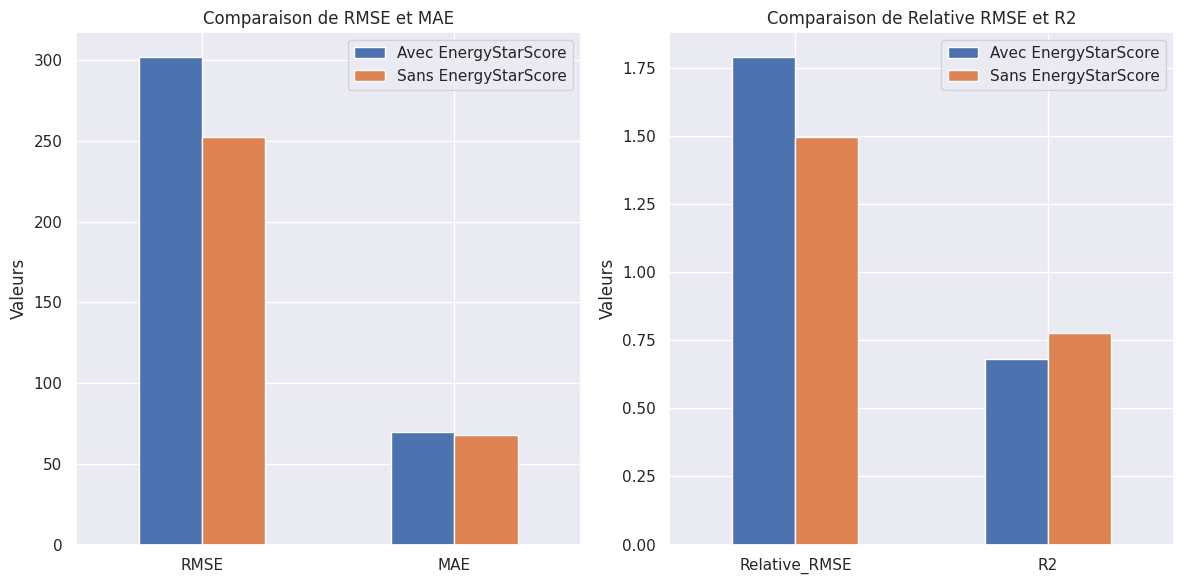

In [33]:
sns.set()

df_rmse_mae = df_score.loc[['RMSE', 'MAE']]
df_relative_r2 = df_score.loc[['Relative_RMSE', 'R2']]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Premier graphique (RMSE et MAE)
df_rmse_mae.plot(kind='bar', ax=axes[0], legend=False)
axes[0].set_title("Comparaison de RMSE et MAE")
axes[0].set_ylabel("Valeurs")
axes[0].legend(loc='upper right', labels=["Avec EnergyStarScore", "Sans EnergyStarScore"])
# plt.xticks(rotation=0) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
# Deuxième graphique (Relative RMSE et R2)
df_relative_r2.plot(kind='bar', ax=axes[1], legend=False)
axes[1].set_title("Comparaison de Relative RMSE et R2")
axes[1].set_ylabel("Valeurs")
axes[1].legend(loc='upper right', labels=["Avec EnergyStarScore", "Sans EnergyStarScore"])
# plt.xticks(rotation=0)  
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()


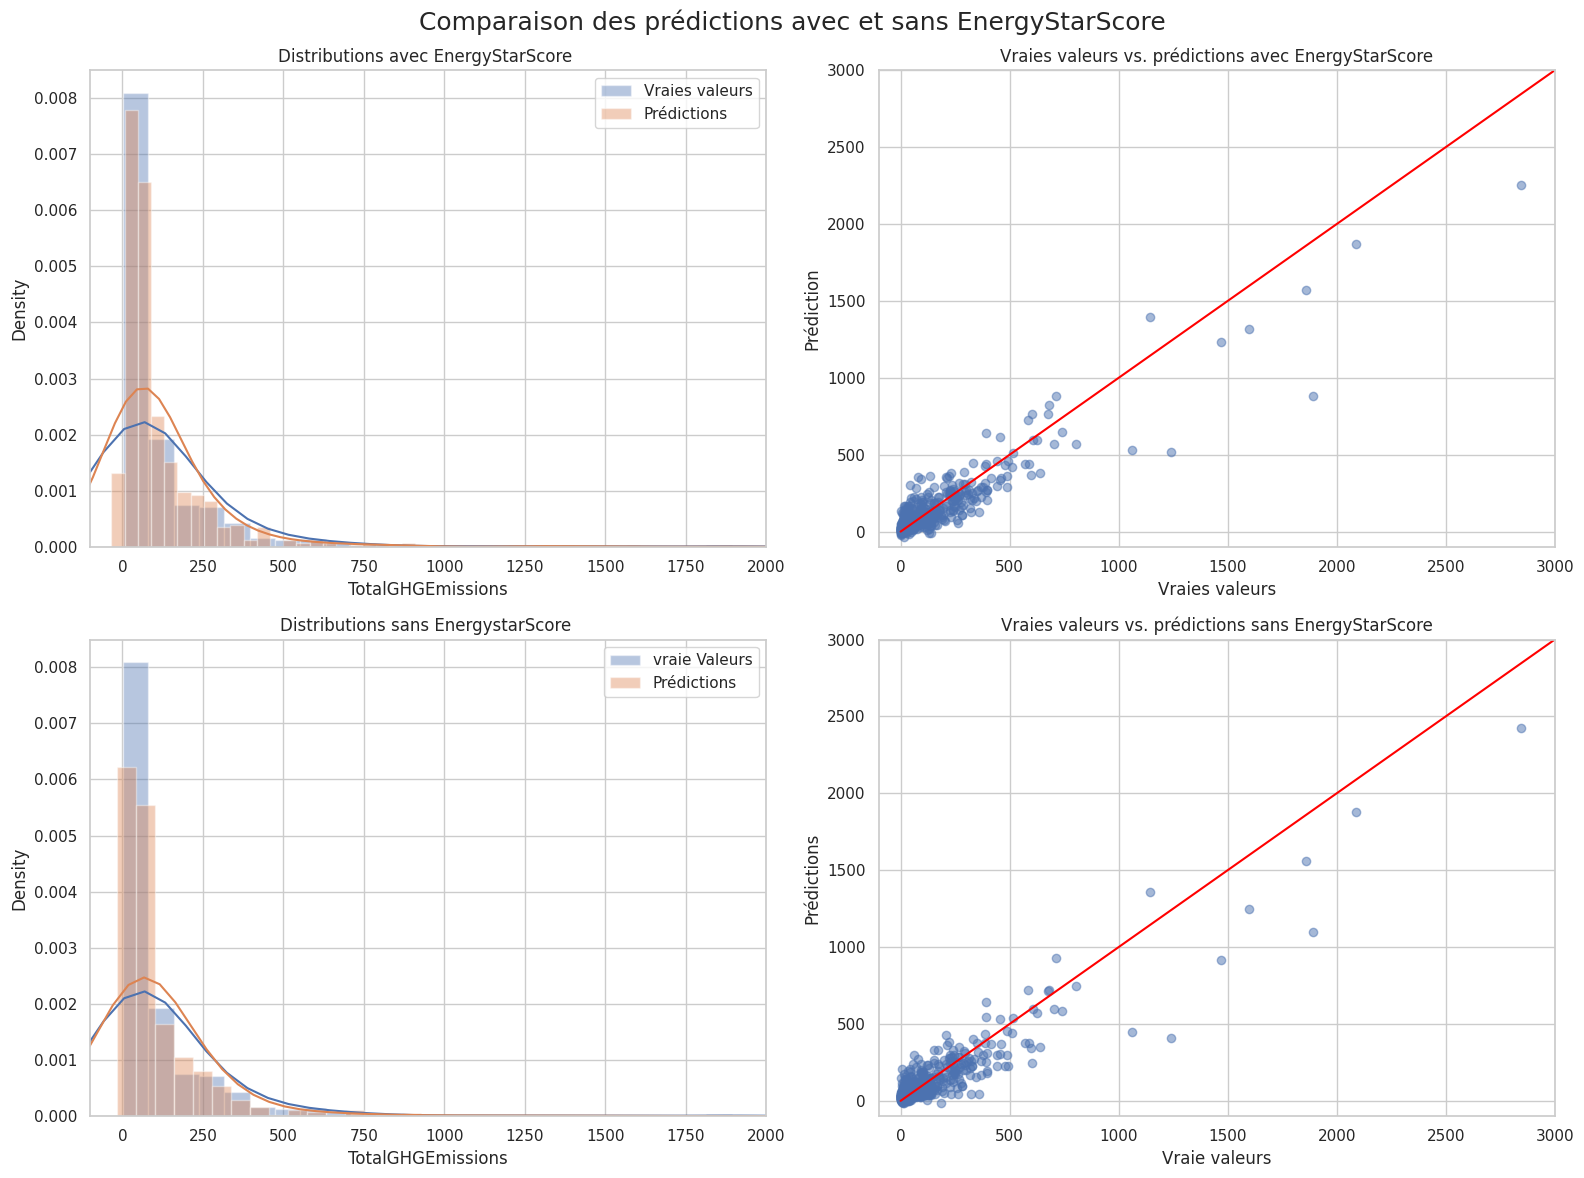

In [38]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16,12))
sns.distplot(y_test, ax = axes[0,0], label='Vraies valeurs', bins=150)
sns.distplot(y_pred, ax = axes[0,0], label='Prédictions', bins=150)
axes[0,0].set_title('Distributions avec EnergyStarScore ')
axes[0,0].legend()
axes[0,0].set_xlim(-100, 2e3)

axes[0,1].scatter(y_test, y_pred, alpha=0.5)
axes[0,1].plot([0, 3e3],[0, 3e3], color = 'red', linestyle = '-', linewidth = 1.5)
axes[0,1].set_xlim(-100, 3e3)
axes[0,1].set_ylim(-100, 3e3)
axes[0,1].set_xlabel("Vraies valeurs")
axes[0,1].set_ylabel("Prédiction")
axes[0,1].set_title("Vraies valeurs vs. prédictions avec EnergyStarScore")

# Graphique données sans EnergyStarScore
sns.distplot(y_test_2, ax = axes[1,0], label='vraie Valeurs' , bins=150)
sns.distplot(y_pred_2, ax = axes[1,0], label='Prédictions', bins=150)
axes[1,0].set_title('Distributions sans EnergystarScore ')
axes[1,0].legend()
axes[1,0].set_xlim(-100, 2e3)

axes[1,1].scatter(y_test_2, y_pred_2, alpha=0.5)
axes[1,1].plot([0, 3e3],[0, 3e3], color = 'red', linestyle = '-', linewidth = 1.5)
axes[1,1].set_xlim(-100, 3e3)
axes[1,1].set_ylim(-100, 3e3)
axes[1,1].set_xlabel("Vraie valeurs")
axes[1,1].set_ylabel("Prédictions")
axes[1,1].set_title("Vraies valeurs vs. prédictions sans EnergyStarScore")

fig.suptitle('Comparaison des prédictions avec et sans EnergyStarScore', fontsize=18)


plt.tight_layout()
plt.show()

- Les scores obtenus par le modèle XGBoost sont meilleurs sans la variable ENERGYSTRAScore, nous avons pourtant vu que cette variable était importante pour notre modèle.
- Cela suggère que la variable a un impact sur certaines prédictions seulement ou alors impacte positivement certaines prédictions et négativement d'autres.
- Pour comprendre ce phénomène, nous allons visualiser l'importante de cette variable sur un échantillon de prédiction :

In [65]:
import shap

explainer = shap.Explainer(model_xgb, X_train)

# 1. Obtenir les valeurs SHAP pour toutes les prédictions
shap_values = explainer.shap_values(X_test)


In [66]:
# 2. Examiner les valeurs SHAP pour 'ENERGYSTARScore'
shap_energy_score = shap_values[:, 10]  # 10 étant l'indice de la variable ENErgySTARScore


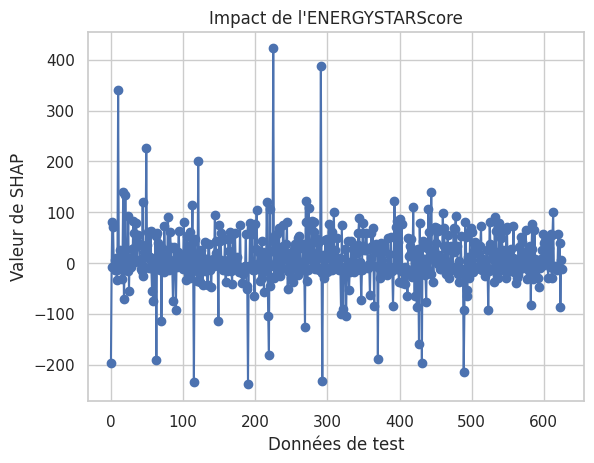

In [67]:
plt.figure()

# Tracé de shap_energy_score
plt.plot(shap_energy_score, marker='o', linestyle='-')
plt.title("Impact de l'ENERGYSTARScore")
plt.xlabel("Données de test")
plt.ylabel("Valeur de SHAP")
plt.show()


In [69]:
prediction_with_high_energy_score = [i for i,value in enumerate(shap_energy_score) if (value > 100) | (value < -100)]
high_selected_predictions = df_energy.iloc[prediction_with_high_energy_score]
high_selected_predictions

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,TotalGHGEmissions,Parking_Rate,Building_Rate
0,NonResidential,Housing/Hotel,2.0,GREATER DUWAMISH,47.547734,-122.320787,1.0,3.0,22452,Housing/Hotel,78.0,44.71,0.000000,100.000000
11,NonResidential,Office,7.0,DOWNTOWN,47.606682,-122.334526,1.0,14.0,186768,Office,95.0,218.49,12.729697,87.270303
20,NonResidential,Office,7.0,DOWNTOWN,47.616735,-122.341981,1.0,12.0,206000,Office,88.0,228.07,0.000000,100.000000
27,NonResidential,Office,7.0,DOWNTOWN,47.615643,-122.335044,1.0,14.0,362046,Office,81.0,129.02,34.389553,65.610447
59,NonResidential,Office,7.0,DOWNTOWN,47.603492,-122.335576,1.0,6.0,205521,Office,93.0,282.72,0.000000,100.000000
64,NonResidential,Health,7.0,MAGNOLIA / QUEEN ANNE,47.619948,-122.360664,1.0,5.0,190000,Health,7.0,371.48,20.526316,79.473684
83,NonResidential,Office,7.0,DOWNTOWN,47.608316,-122.335449,1.0,8.0,321945,Office,79.0,266.18,0.000000,100.000000
91,NonResidential,Office,6.0,LAKE UNION,47.650609,-122.353058,1.0,3.0,124071,Office,77.0,33.02,0.000000,100.000000
149,SPS-District K-12,Education,4.0,NORTHEAST,47.682450,-122.293935,1.0,2.0,175565,Education,88.0,258.67,0.000000,100.000000
152,NonResidential,Office,7.0,DOWNTOWN,47.610014,-122.332394,1.0,56.0,1605578,Office,97.0,496.99,24.281598,75.718402


In [70]:
high_selected_predictions.ENERGYSTARScore.describe()

count    35.000000
mean     65.885714
std      27.502697
min       4.000000
25%      50.000000
50%      77.000000
75%      88.000000
max      97.000000
Name: ENERGYSTARScore, dtype: float64

In [71]:
high_selected_predictions.TotalGHGEmissions.describe()

count     35.000000
mean     153.856286
std      154.093370
min        7.210000
25%       38.520000
50%       92.680000
75%      247.180000
max      675.340000
Name: TotalGHGEmissions, dtype: float64

In [54]:
shap.initjs()

In [56]:
model_xgb.fit(X_train, y_train)

# Créer un objet explainer SHAP
explainer = shap.Explainer(model_xgb.predict, X_train, feature_names=X_train.columns)

# Obtenir des explications SHAP 
shap_values_2 = explainer(X_test)

PermutationExplainer explainer: 627it [00:49, 10.16it/s]                        


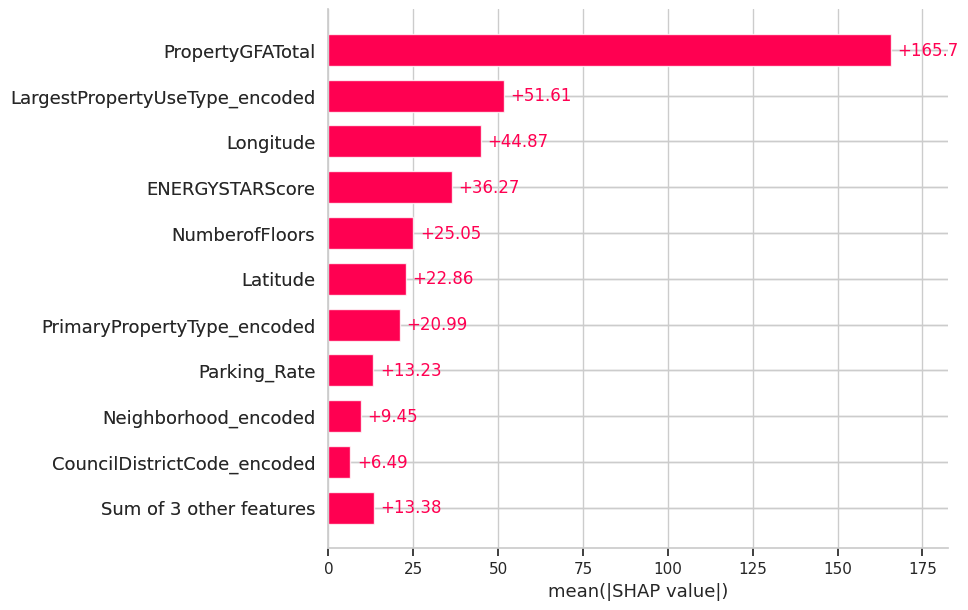

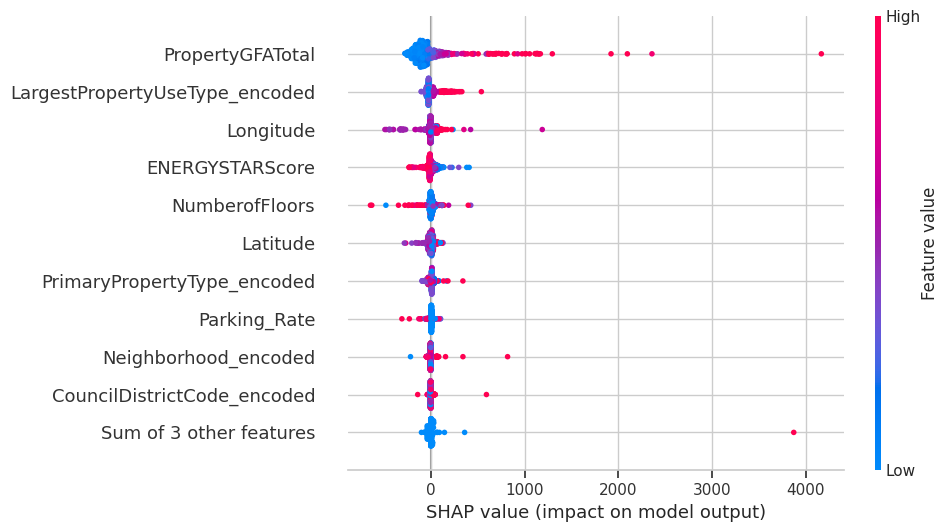

In [57]:
shap.plots.bar(shap_values_2, max_display=11)
shap.plots.beeswarm(shap_values_2, max_display=11)

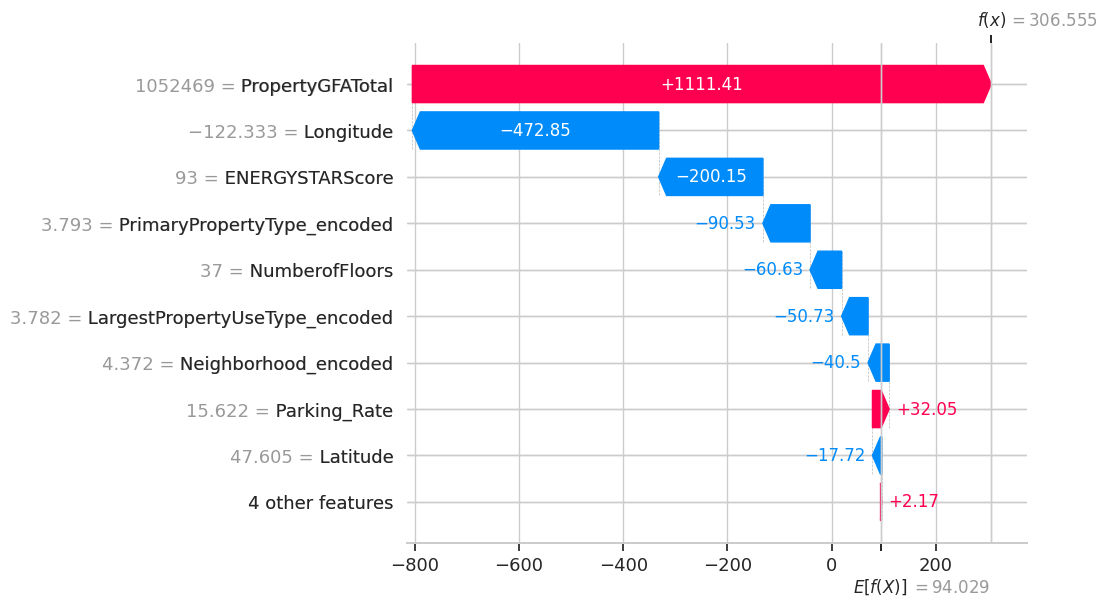

In [60]:
shap.plots.waterfall(shap_values_2[0])

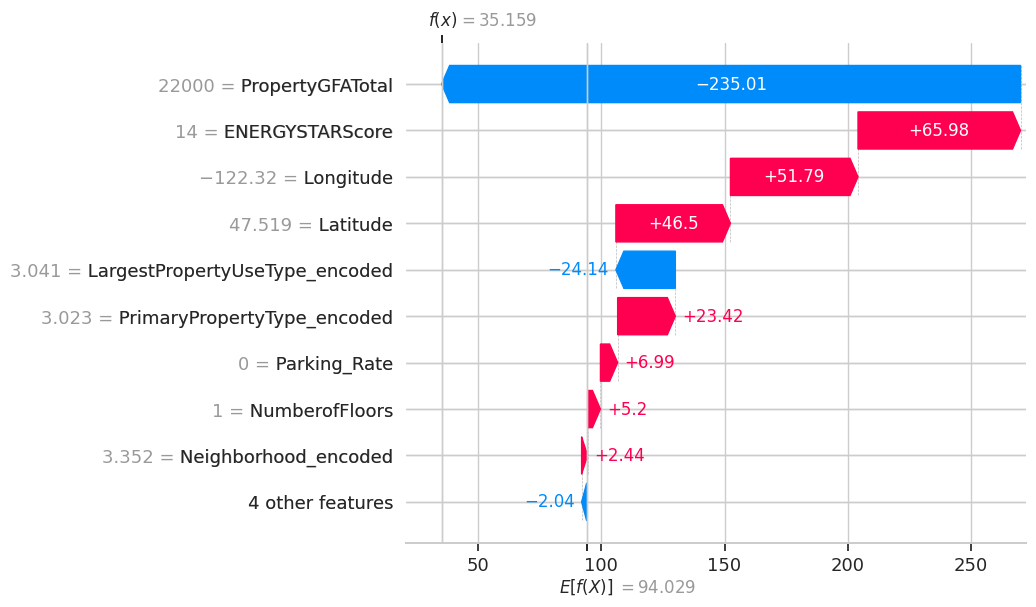

In [61]:
shap.plots.waterfall(shap_values_2[82])

- Nous avons constaté que la variable ENERGYSTARScore a une importance pour le modèle mais n'apporte pas de précision. 
- Ce constat a été fait sur le dataset sélectionné (données restreintes à l'ENERGYSTARScore) 
- La sélection effectuée a t-elle impacté la distribution de la variable cible ?

#### Test de Kolmogorov-Smirnov : 

Comparer la distribution de la variable cible avant et après restriction à l'ENERGYSTARScore

In [62]:
from scipy.stats import ks_2samp

# Les données à comparer : la distribution des émissions de CO2
# Issue du data set initial et dataset restreint à ENERGYStrarScore

group_all = data['TotalGHGEmissions']
group_ess = df['TotalGHGEmissions']

# Effectuer le test de Kolmogorov-Smirnov
ks_statistic, p_value = ks_2samp(group_all, group_ess)

# Afficher les résultats
print("Test de Kolmogorov-Smirnov :")
print("---------------------------")
print(f"Statistique KS = {ks_statistic}")
print(f"Valeur de p = {p_value}")

# Interpréter les résultats
alpha = 0.05  # Niveau de signification
if p_value < alpha:
    print("Les distributions des émissins de CO2 sont différentes.")
else:
    print("Les distributions des émissins de CO2 sont identiques.")


Test de Kolmogorov-Smirnov :
---------------------------
Statistique KS = 0.01701544905374852
Valeur de p = 0.6404317719751159
Les distributions des émissins de CO2 sont identiques.


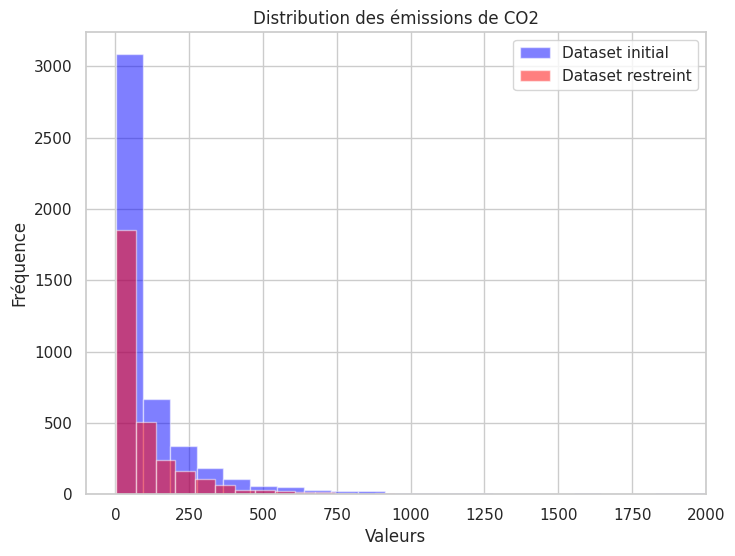

In [63]:


# Histogrammes des deux groupes
plt.figure(figsize=(8, 6))
plt.hist(group_all, bins=250, alpha=0.5, label='Dataset initial', color='blue')
plt.hist(group_ess, bins=250, alpha=0.5, label='Dataset restreint', color='red')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.xlim(-1e2, 2e3)
plt.legend()
plt.title('Distribution des émissions de CO2')
plt.show()


Le test indique que la distribution des émissions de CO2 n'a pas été modifiée par la restriction des données à ENERGYSTARScore. 

### Conclusion :
Les scores obtenus et le test statistique montre que la variable ENERGYSTARScore n'est pas pertinente pour prédire les émissions de CO2